# Исследование поведения игроков игры "Космические братья"

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения.

Целью исследования является анализ поведения игроков в зависимости от источника перехода.

Предстоит проверить 2 гипотезы:
- время завершения уровня различается в зависимости игровой стратегии
- тип игровой стратегии зависит от источника привлечения


## Описание данных

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Датасет *ad_costs.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет *user_source.csv*:

- `user_id` - идентификатор пользователя
- `source` - источник, с которого пришёл пользователь, установивший приложение

## Загрузка данных и библиотек

In [1]:
# загрузка библиотек

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats as st
import math as mth
import plotly.io as pio
pio.renderers.default = "browser"

In [2]:
pd.options.display.float_format = '{: .2f}'.format

In [3]:
# загрузка данных о юзерах

users = pd.read_csv(r"C:\Users\N\OneDrive\Desktop\study\ipynb\my projects\final_project\user_source.csv")

In [4]:
# загрузка данных о тратах на привлечение

ad_costs = pd.read_csv(r"C:\Users\N\OneDrive\Desktop\study\ipynb\my projects\final_project\ad_costs.csv")

In [5]:
# загрузка данных о событиях в игре

game_log = pd.read_csv(r"C:\Users\N\OneDrive\Desktop\study\ipynb\my projects\final_project\game_actions.csv")

## Предподготовка данных

In [6]:
def df_info(df):
    
    """Функция выводит размер и информацию о датафрейме head(), info(), информацию о явных дубликатах"""
    
    display(df.head())
    print('\nРазмер датасета', df.shape[0], '\n')
    print('Пропуски в данных и типы данных:\n')
    df.info()
    print('\nЯвные дубликаты:', df.duplicated().sum())

### Данные о пользователях

In [7]:
df_info(users)

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads



Размер датасета 13576 

Пропуски в данных и типы данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB

Явные дубликаты: 0


Пропусков в датасете нет.

Дубликатов нет.

In [8]:
# все ли юзеры уникальны?

users['user_id'].nunique()

13576

Да, в датасете все юзеры уникальные.

In [9]:
# какакие уникальные источники привлечения есть

users['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Итак, у нас 4 источника: FaceBook, Яндекс.Директ, YouTube, Instagram

### Данные о рекламных затратах

In [10]:
df_info(ad_costs)

,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77



Размер датасета 28 

Пропуски в данных и типы данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes

Явные дубликаты: 0


Дубликатов и пропусков в датасете нет.

In [11]:
# меняем тип данных во временной колонке

ad_costs['day'] = pd.to_datetime(ad_costs['day'], format='%Y-%m-%d')

In [12]:
#check

ad_costs.dtypes

source            object
day       datetime64[ns]
cost             float64
dtype: object

In [13]:
ad_costs['day'].agg({'min','max'})

min   2020-05-03
max   2020-05-09
Name: day, dtype: datetime64[ns]

Данные представлены с 3 по 9 мая 2020 года.

### Данные о событиях в игре

In [14]:
df_info(game_log)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN



Размер датасета 135640 

Пропуски в данных и типы данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB

Явные дубликаты: 1


In [15]:
game_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [16]:
# заменим тип временной колонки

game_log['event_datetime'] = pd.to_datetime(game_log['event_datetime'], format='%Y-%m-%d %H:%M:%S')

In [17]:
# check

game_log.dtypes

event_datetime    datetime64[ns]
event                     object
building_type             object
user_id                   object
project_type              object
dtype: object

In [18]:
# пропуски есть, оценим их долю

game_log.isna().mean()

event_datetime    0.00
event             0.00
building_type     0.06
user_id           0.00
project_type      0.99
dtype: float64

Характер пропусков в столбцах изучем позже в процессе EDA.

In [19]:
# избавимся от найденного дубликата

game_log = game_log.drop_duplicates()

In [20]:
# check

game_log.duplicated().sum()

0

In [21]:
game_log['event_datetime'].agg({'min','max'})

min   2020-05-04 00:00:01
max   2020-06-05 12:32:49
Name: event_datetime, dtype: datetime64[ns]

Данные о событиях в игре представлены с 4 мая по 5 июня 2020 года (почти за месяц).

## Исследовательский анализ данных

### Распределение пользователей по источникам привлечения

In [22]:
# посмотрим, откуда приходят пользователи

users_by_source = users.groupby('source', as_index=False).agg({'user_id':'nunique'}).sort_values(by='source')
users_by_source

,source,user_id
0,facebook_ads,2726
1,instagram_new_adverts,3347
2,yandex_direct,4817
3,youtube_channel_reklama,2686


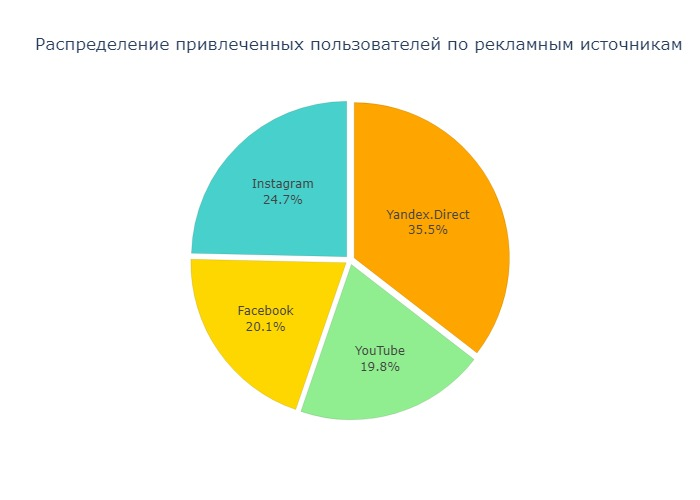

In [23]:
# смотрим распределение пользователей по источникам

fig = px.pie(
             users_by_source,
             values='user_id',
             names='source',
             title='Распределение привлеченных пользователей по рекламным источникам'
             )

colors=['gold', 'mediumturquoise', 'orange', 'lightgreen']

fig.update_traces(
                  labels=['Facebook', 'Instagram', 'Yandex.Direct', 'YouTube'],
                  textposition='inside',
                  textinfo='percent+label',
                  marker=dict(colors=colors, line=dict(color='#000000', width=0.1)),
                  pull=[0.03, 0.03, 0.03, 0.03],
                  showlegend=False
                        )
fig.show(renderer='jpeg')

**Яндекс.Директ** привлекает больше всего пользователей - **почти 35%**.

**Instagram** занимает второе место по привлечению - **почти 25%**.

**Остальные источники** примерно одинаковы - **около 20%**.

### Распределение трат по источникам привлечения, подсчет САС

In [24]:
# смотрим, сколько потрачено на привлечение через каждый источник

costs_by_source = ad_costs.groupby('source', as_index=False).agg({'cost':'sum'}).sort_values(by='source')
costs_by_source['cost'] = costs_by_source['cost'].astype('int')
costs_by_source

,source,cost
0,facebook_ads,2140
1,instagram_new_adverts,2161
2,yandex_direct,2233
3,youtube_channel_reklama,1068


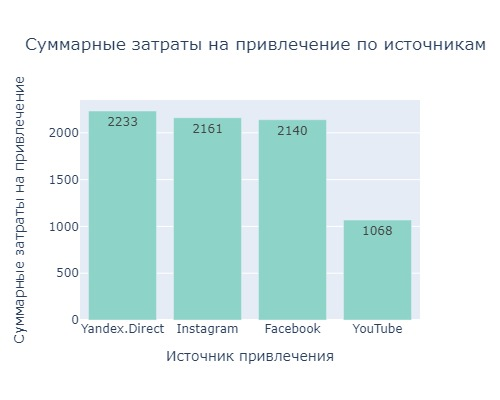

In [25]:
# посмотрим на суммарные затраты на привлечение по источникам в абсолютных величинах 

fig = px.bar(costs_by_source.sort_values(by='cost', ascending=False),
             x=['Yandex.Direct', 'Instagram', 'Facebook', 'YouTube'],
             y='cost',
             text='cost',
             title='Суммарные затраты на привлечение по источникам',
             labels={'x': 'Источник привлечения',
                     'cost': 'Суммарные затраты на привлечение'},
             width=500, height=400,
             color_discrete_sequence=px.colors.qualitative.Set3
             )

fig.update_traces(hoverinfo='skip')
fig.show(renderer='jpeg') 

Траты на FaceBook, Яндекс.Директ и Инстаграм примерно одинаковы. На YouTube было выделено в 2 раза меньше денег.

In [26]:
# посчитаем САС

users_by_source['CAC'] = round(costs_by_source['cost'] / users_by_source['user_id'], 2)

In [27]:
users_by_source.sort_values(by='CAC', ascending=False)

,source,user_id,CAC
0,facebook_ads,2726,0.79
1,instagram_new_adverts,3347,0.65
2,yandex_direct,4817,0.46
3,youtube_channel_reklama,2686,0.40


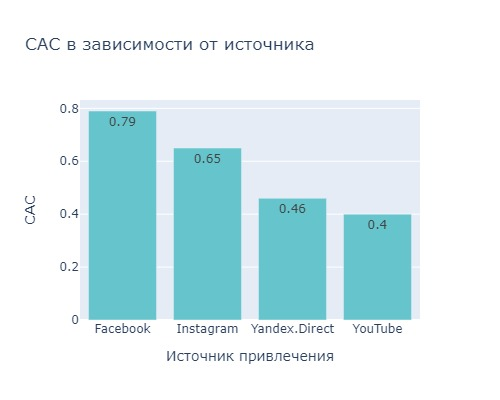

In [28]:
# смотрим, как распределяется САС по источникам привлечения

x=['Facebook', 'Instagram', 'Yandex.Direct', 'YouTube']

fig = px.bar(users_by_source,
             x=x,
             y='CAC',
             text='CAC',
             title='САС в зависимости от источника',
             labels={'x': 'Источник привлечения'},
             width=500, height=400,
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show(renderer='jpeg') 

Яндекс.Директ приносит больше всего пользователей, причем недорогих пользователей. 

Однако, **самые дешевые пользователи приходят с Youtube**.

### Изучение поведения пользователей в игре:

#### Какие типы игровой стратегии можно выделить?

In [29]:
# посмотрим, какие события есть в датасете

game_log['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

Попытаемся разобраться в стратегиях, которые применяют пользователи.

In [30]:
# для начала выделим юзеров, которые уже завершили первый уровень

level_finished = game_log.query('event == "finished_stage_1"')
level_finished_list = list(level_finished['user_id'])

In [31]:
# сделаем срез данных только с теми пользователями, которые уже закончили уровень

only_finished_users = game_log.query('user_id in @level_finished_list')

Так как возможны 2 стратегии победы: через строительство орбитального проекта (назовем их **строителями**) и через победу над врагом (назовем их **воителями**), попробуем отделить пользователей друг от друга по выбранной стратегии.

In [32]:
# список пользователей, завершивших строительство проекта - строители

builders = game_log.loc[game_log['event'] == 'project']
builders_list = list(builders['user_id'].unique())

In [33]:
# датасет с пользователями - строителями

builders_data = only_finished_users.query('user_id in @builders_list')
builders_data['user_id'].nunique()

1866

In [34]:
# датасет с пользователями - воителями

fighters_data = only_finished_users.query('user_id not in @builders_list')
fighters_data['user_id'].nunique()

3951

**Почти в 2 раза больше пользователей предпочитают драться, чем строить.**

#### Сколько пользователи проводят времени  в игре?

Посмотрим, сколько действий в среднем совершают пользователи, в зависимости от игровой стратегии

In [35]:
# строители

builders_data.groupby('user_id').agg({'event':'count'}).median()

event    14.00
dtype: float64

In [36]:
# воители

fighters_data.groupby('user_id').agg({'event':'count'}).median()

event    11.00
dtype: float64

Строители в среднем совершают больше действий в игре: это логично, так как для победы строителям нужно совершить минимум 2 действия, а воителям - одно.

Посмотрим, сколько построек в среднем строят игроки из обеих групп.

In [37]:
# сколько зданий строят строители

builders_data.query('event == "building"').groupby('user_id').agg({'event':'count'}).median()

event    12.00
dtype: float64

In [38]:
# сколько зданий строят воители

fighters_data.query('event == "building"').groupby('user_id').agg({'event':'count'}).median()

event    10.00
dtype: float64

И строители, и воители строят объекты, но в среднем строители строят на 20% больше зданий, чем воители, следовательно на 20% чаще видят карточки с постройками.

#### Cколько пользователи тратят времени на 1й уровень

In [39]:
# строители 

builders_time = builders_data.groupby('user_id', as_index=False).agg({'event_datetime':['min','max']})
builders_time.columns=['user_id', 'min', 'max']
builders_time.head()

,user_id,min,max
0,006380d6-67a6-45de-ab1e-6eb54ad8dbe8,2020-05-04 16:43:39,2020-05-16 11:22:33
1,00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,2020-05-08 21:57:44,2020-05-24 19:05:12
2,00c2b9f2-2615-439c-aed0-6974e4c6c1c1,2020-05-07 10:26:09,2020-05-27 11:38:47
3,00de2809-403e-4476-a2f7-ca1b11700190,2020-05-04 07:48:50,2020-05-18 09:34:10
4,00e83261-5fd4-4939-9616-802b5a0202c6,2020-05-05 15:49:57,2020-05-20 09:35:04


In [40]:
# сколько в среднем занимает у строителей пройти первый уровень (в часах)

builders_time['duration'] = builders_time['max'] - builders_time['min']
builders_time['hours'] = builders_time['duration'].apply(lambda x: x/np.timedelta64(1,'h'))

In [41]:
# смотрим статистику по затраченному времени у строителей

builders_time['hours'].describe()

count    1866.00
mean      323.01
std        84.18
min       123.37
25%       262.83
50%       312.76
75%       373.79
max       699.23
Name: hours, dtype: float64

**Строители** затрачивают порядка **312 часов** на завершение первого уровня (медианное значение) - **13 дней**.

In [42]:
# воители 

fighters_time = fighters_data.groupby('user_id', as_index=False).agg({'event_datetime':['min','max']})
fighters_time.columns=['user_id', 'min', 'max']
fighters_time.head()

,user_id,min,max
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39


In [43]:
# сколько в среднем занимает у воителей пройти первый уровень (в часах)

fighters_time['duration'] = fighters_time['max'] - fighters_time['min']
fighters_time['hours'] = fighters_time['duration'].apply(lambda x: x/np.timedelta64(1,'h'))
fighters_time.head()

,user_id,min,max,duration,hours
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,154.65
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,12 days 13:16:45,301.28
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,12 days 18:50:05,306.83
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,11 days 07:26:32,271.44
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,6 days 01:58:52,145.98


In [44]:
# смотрим статистику по по затраченному времени у воителей

fighters_time['hours'].describe()

count    3951.00
mean      266.51
std        98.30
min         9.65
25%       199.02
50%       259.03
75%       322.55
max       741.98
Name: hours, dtype: float64

**Воители** затрачивают порядка **259 часов** на завершение первого уровня (медианное значение) - **почти 11 дней**.

In [45]:
# добавим категорию стратегии в датасет со стороителями

builders_time['strategy'] = 'builder'

In [46]:
# добавим источник привлечения

builders = builders_time.merge(users, on='user_id', how='left')
builders.head()

,user_id,min,max,duration,hours,strategy,source
0,006380d6-67a6-45de-ab1e-6eb54ad8dbe8,2020-05-04 16:43:39,2020-05-16 11:22:33,11 days 18:38:54,282.65,builder,youtube_channel_reklama
1,00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,2020-05-08 21:57:44,2020-05-24 19:05:12,15 days 21:07:28,381.12,builder,instagram_new_adverts
2,00c2b9f2-2615-439c-aed0-6974e4c6c1c1,2020-05-07 10:26:09,2020-05-27 11:38:47,20 days 01:12:38,481.21,builder,youtube_channel_reklama
3,00de2809-403e-4476-a2f7-ca1b11700190,2020-05-04 07:48:50,2020-05-18 09:34:10,14 days 01:45:20,337.76,builder,instagram_new_adverts
4,00e83261-5fd4-4939-9616-802b5a0202c6,2020-05-05 15:49:57,2020-05-20 09:35:04,14 days 17:45:07,353.75,builder,yandex_direct


In [47]:
# добавим категорию стратегии в датасет с воителями

fighters_time['strategy'] = 'fighter'

In [48]:
# добавим источник привлечения

fighters = fighters_time.merge(users, on='user_id', how='left')
fighters.head()

,user_id,min,max,duration,hours,strategy,source
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,154.65,fighter,instagram_new_adverts
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,12 days 13:16:45,301.28,fighter,instagram_new_adverts
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,12 days 18:50:05,306.83,fighter,facebook_ads
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,11 days 07:26:32,271.44,fighter,yandex_direct
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,6 days 01:58:52,145.98,fighter,instagram_new_adverts


In [49]:
# соберем общий датасет с источниками, стратегией игры и продолжительностью игры

agg_data = pd.concat([fighters, builders], 
                                axis=0,
                                join="outer",
                                ignore_index=True)

In [50]:
agg_data.head()

,user_id,min,max,duration,hours,strategy,source
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,154.65,fighter,instagram_new_adverts
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,12 days 13:16:45,301.28,fighter,instagram_new_adverts
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,12 days 18:50:05,306.83,fighter,facebook_ads
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,11 days 07:26:32,271.44,fighter,yandex_direct
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,6 days 01:58:52,145.98,fighter,instagram_new_adverts


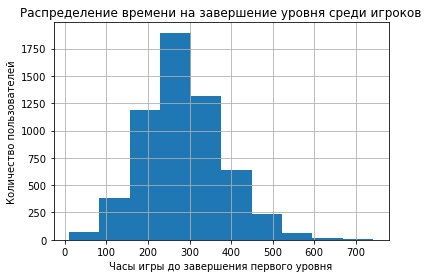

In [51]:
agg_data['hours'].hist()
plt.title('Распределение времени на завершение уровня среди игроков')
plt.xlabel('Часы игры до завершения первого уровня')
plt.ylabel('Количество пользователей');

Распределение времени игры выглядит нормальным.

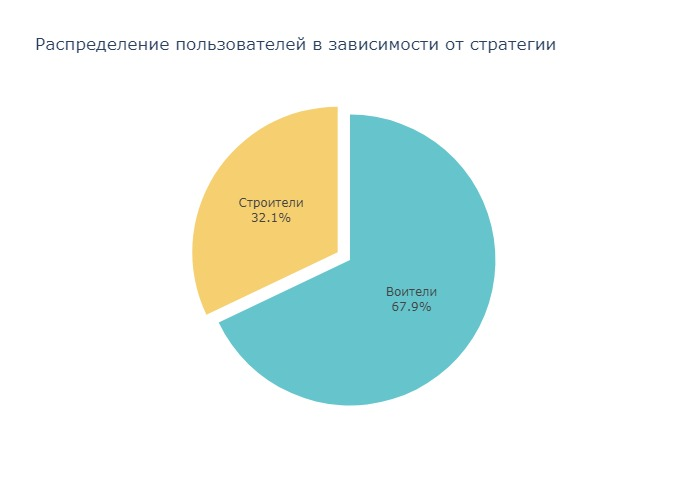

In [52]:
# смотрим как распределяются пользователи в зависимости от стратегии

fig = px.pie(
             agg_data.groupby('strategy', as_index=False).agg({'user_id':'nunique'}),
             values='user_id',
             names='strategy',
             title='Распределение пользователей в зависимости от стратегии',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             )

fig.update_traces(
                  labels=['Строители', 'Воители'],
                  textposition='inside',
                  textinfo='percent+label',
                  pull=[0.1, 0.0],
                  showlegend=False
                        )
fig.show(renderer='jpeg')

In [53]:
# смотрим медианное затраченное время на прохождение уровня

hours_by_strategy = agg_data.groupby('strategy', as_index=False).agg({'hours':'median'})
hours_by_strategy['hours'] = hours_by_strategy['hours'].astype('int')
hours_by_strategy['days'] = (hours_by_strategy['hours'] // 24).astype('int')
hours_by_strategy['duration'] = (
                                ((hours_by_strategy['hours'] // 24).astype('int')).astype('str') + 
                                 ' дней ' + 
                                 (hours_by_strategy['hours'].astype(int) - hours_by_strategy['days']*24).astype('str') +
                                 ' часов '
                                )
hours_by_strategy

,strategy,hours,days,duration
0,builder,312,13,13 дней 0 часов
1,fighter,259,10,10 дней 19 часов


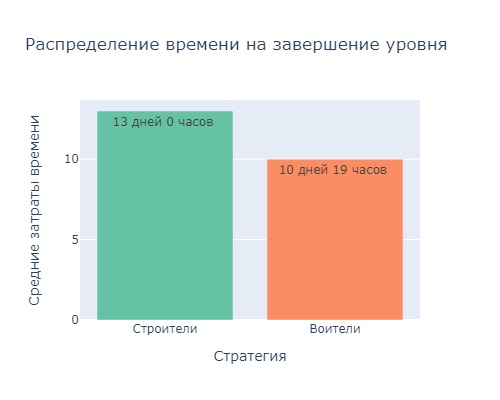

In [54]:
# сравним средние временные затраты на прохождение первого уровня в зависимости от стратегии

fig = px.bar(hours_by_strategy,
             x=['Строители', 'Воители'],
             y='days',
             color='strategy',
             text='duration',
             title='Распределение времени на завершение уровня',
             labels={'x': 'Стратегия',
                    'days': 'Средние затраты времени'},
             color_discrete_sequence=px.colors.qualitative.Set2,
             width=500, height=400,
                 )
fig.update_traces(showlegend=False)
fig.show(renderer='jpeg') 

**Очевидно, строители тратят больше времени на прохождение уровня, чем воители.**

In [55]:
# посмотрим сколько времени тратят игроки на прохождение первого уровня в зависимости от источника привлечения

hours_by_source = (
                    agg_data.groupby('source', as_index=False)
                            .agg({'hours':'median'})
                            .sort_values(by='hours', ascending=False)
                    )

hours_by_source['hours'] = hours_by_source['hours'].astype('int')
hours_by_source

,source,hours
3,youtube_channel_reklama,278
1,instagram_new_adverts,278
0,facebook_ads,278
2,yandex_direct,276


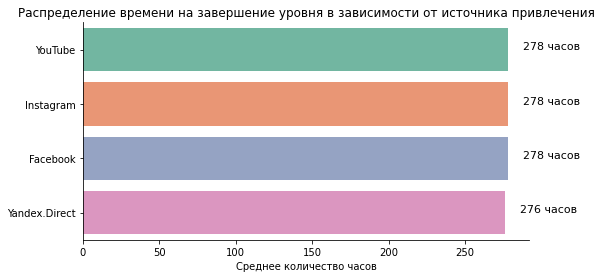

In [56]:
plt.figure(figsize=(8, 4))
sns.barplot(
            y=['YouTube', 'Instagram', 'Facebook', 'Yandex.Direct'],
            x='hours',
            data=hours_by_source,
            palette='Set2',
            orient='h'
           )
plt.title('Распределение времени на завершение уровня в зависимости от источника привлечения')
plt.xlabel('Среднее количество часов')
plt.ylabel('')
sns.despine();

for i, v in enumerate(hours_by_source['hours']):
    plt.text(v+10, i, str(v) + ' часов', color='black', fontsize = 11)

**Медианное количество часов до завершения уровня не зависит от источника привлечения.**

#### Как типы игровой стратегии связаны с источником привлечения?

Посмотрим, какая связь есть между стратегией игры и источником привлечения.

In [57]:
# группируем по источнику и стратегии

strategy_by_source = (
                    agg_data.groupby(['source','strategy'], as_index=False)
                            .agg({'user_id':'nunique'})
                            .sort_values(by='user_id', ascending=False)
                        )
strategy_by_source

,source,strategy,user_id
5,yandex_direct,fighter,1422
3,instagram_new_adverts,fighter,990
7,youtube_channel_reklama,fighter,780
1,facebook_ads,fighter,759
4,yandex_direct,builder,620
2,instagram_new_adverts,builder,476
0,facebook_ads,builder,391
6,youtube_channel_reklama,builder,379


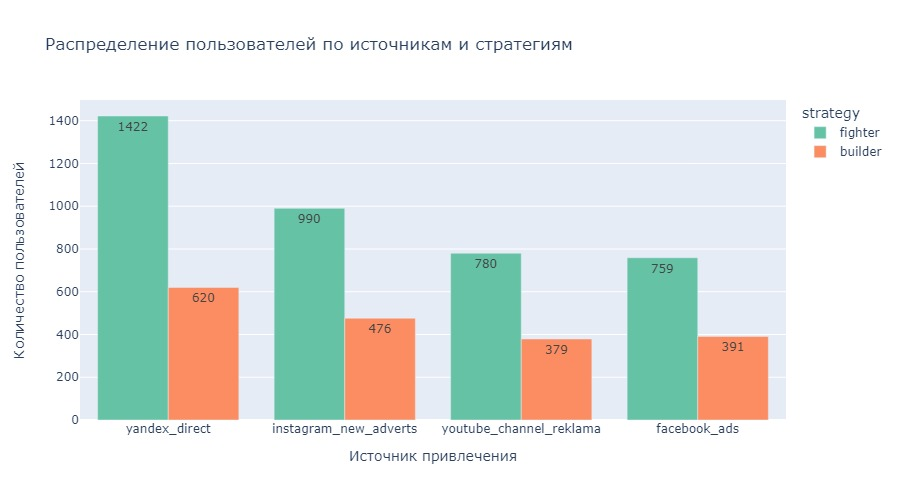

In [58]:
# посмотрим разбиением по источникам и по стратегиям игры

fig = px.bar(
            strategy_by_source, 
            x='source', 
            y='user_id', 
            color='strategy', 
            barmode='group', 
            text_auto=True,
            color_discrete_sequence=px.colors.qualitative.Set2,
            height=500,
            width=900,
            title='Распределение пользователей по источникам и стратегиям',
            labels={'source': 'Источник привлечения',
                    'user_id': 'Количество пользователей'}
            )
fig.show(renderer='jpeg')

Вне зависимости от источника привлечения пользователи предпочитают воевать, а не строить.

Так как нас интересуют именно строители, которые проводят больше времени в игре, а также одна из моделей монетизации нацелена на них, посмотрим, какой источник дает больше строителей.

In [59]:
# воители в зависимости от источника

fighters_by_source = fighters.groupby('source', as_index=False).agg({'user_id':'nunique'})
fighters_by_source.head()

,source,user_id
0,facebook_ads,759
1,instagram_new_adverts,990
2,yandex_direct,1422
3,youtube_channel_reklama,780


In [60]:
# строители в зависимости от источника

builders_by_source = builders.groupby('source', as_index=False).agg({'user_id':'nunique'})
builders_by_source.head()

,source,user_id
0,facebook_ads,391
1,instagram_new_adverts,476
2,yandex_direct,620
3,youtube_channel_reklama,379


In [61]:
# смотрим соотношение строителей к воителям

source = builders_by_source.merge(fighters_by_source, on='source')
source.columns = ['source', 'builders', 'fighters']
source['number_of_users'] = source['builders'] + source['fighters']
source['builders, %'] = source['builders'] / source['number_of_users']
source['fighters, %'] = source['fighters'] / source['number_of_users']
source['builders_to_fighters'] = round(source['builders'] / source['fighters'], 2)
source = source.sort_values(by='builders_to_fighters', ascending=False)
source

,source,builders,fighters,number_of_users,"builders, %","fighters, %",builders_to_fighters
0,facebook_ads,391,759,1150,0.34,0.66,0.52
3,youtube_channel_reklama,379,780,1159,0.33,0.67,0.49
1,instagram_new_adverts,476,990,1466,0.32,0.68,0.48
2,yandex_direct,620,1422,2042,0.30,0.70,0.44


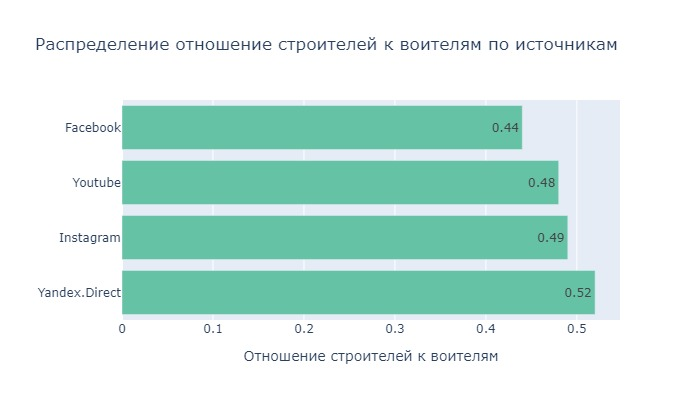

In [62]:
# строим столбчатую диаграмму

fig = px.bar(
            source, 
            y=['Yandex.Direct', 'Instagram', 'Youtube', 'Facebook'], 
            x='builders_to_fighters', 
            text_auto=True,
            color_discrete_sequence=px.colors.qualitative.Set2,
            height=400,
            width=700,
            orientation='h',
            title='Распределение отношение строителей к воителям по источникам',
            labels={'y': '',
                    'builders_to_fighters': 'Отношение строителей к воителям'}
            )
fig.show(renderer='jpeg')

В результате мы видим, что Facebook приносит больше всего строителей, а Яндекс.Директ - меньше всего.

### Проверка гипотез

**Гипотеза 1**

Нулевая гипотеза:
Время завершения уровня различается в зависимости от игровой стратегии

Альтернативная гипотеза:
Время завершения уровня не различается в зависимости от игровой стратегии

In [63]:
# проверка альтернативной гипотезы

results = st.ttest_ind(builders['hours'], fighters['hours'], equal_var=False )

alpha = 0.05

# вывод значения p-value на экран 
print('p-value =', results.pvalue) 

if results.pvalue < alpha:
    print('\nАльтернативная гипотеза не подтвердилась. Время завершения уровня различается в зависимости игровой стратегии.\n')
    print('Среднее время завершения уровня для строителей: ', hours_by_strategy['hours'][0], ' часов.')
    print('Среднее время завершения уровня для воителей: ', hours_by_strategy['hours'][1], ' часов.')
else:
    print('Не получилось отвергнуть гипотезу. Среднее время завершения уровня не отличается.')

p-value = 5.708058235071826e-107

Альтернативная гипотеза не подтвердилась. Время завершения уровня различается в зависимости игровой стратегии.

Среднее время завершения уровня для строителей:  312  часов.
Среднее время завершения уровня для воителей:  259  часов.


<a id='bonferroni'></a>
**Гипотеза 2**
Тип игровой стратегии зависит от источника привлечения.

Нулевая гипотеза: доля строителей отличается в зависимости от источника привлечения. 

Альтернативная гипотеза: доля строителей не зависит от источника привлечения.

Так как планируется множественная проверка гипотезы (6
сочетаний), необходимо внести поправку на множественную проверку гипотез. В таком случае повышается вероятность появления ошибки первого рода. 

**Было принято решение ввести поправку Бонферрони (m=6).**

In [64]:
# список источников привлечения

sources = ad_costs['source'].unique()

In [65]:
# сочетания источников для проверки гипотезы

pair=[]
combined_list=[]

for i in range(len(sources)):
    for j in range (i, len(sources)):
        if sources[i] != sources[j]:
            pair.append(sources[i])
            pair.append(sources[j])
            combined_list.append(pair)
            pair=[]
       
combined_list      

[['facebook_ads', 'instagram_new_adverts'],
 ['facebook_ads', 'yandex_direct'],
 ['facebook_ads', 'youtube_channel_reklama'],
 ['instagram_new_adverts', 'yandex_direct'],
 ['instagram_new_adverts', 'youtube_channel_reklama'],
 ['yandex_direct', 'youtube_channel_reklama']]

In [66]:
# функция для расчета статистической значимости долей строителей в зависимости от источника привлечения

def get_z_test(alpha):
    
   # перебираем пары источников и сравлниваем

    for i in range(len(combined_list)):
        
      
        builders = [
                    source.loc[source['source'] == combined_list[i][0]]['builders'].iloc[0],
                    source.loc[source['source'] == combined_list[i][1]]['builders'].iloc[0]
                   ]

        total_users = [
                    source.loc[source['source'] == combined_list[i][0]]['number_of_users'].iloc[0],
                    source.loc[source['source'] == combined_list[i][1]]['number_of_users'].iloc[0]
                    ]

        # пропорция успехов в первой группе:
        p1 = builders[0]/total_users[0]

        # пропорция успехов во второй группе:
        p2 = builders[1]/total_users[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (builders[0] + builders[1]) / (total_users[0] + total_users[1])

        # разница пропорций в датасетах
        difference = p1 - p2 

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users[0] + 1/total_users[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  
        
        # рассчитываем p-value
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print()
        print(combined_list[i])             
        print('p-value =', p_value)
        
        if p_value < alpha/6:
            print('Между долями есть значимая разница')
        else:
            print('Нет оснований считать доли строителей различными')

In [67]:
# проводим множественный тест, сравнивая доли строителей в источниках попарно, уровень значимости = 0,05/6

get_z_test(0.05)


['facebook_ads', 'instagram_new_adverts']
p-value = 0.4090854890030924
Нет оснований считать доли строителей различными

['facebook_ads', 'yandex_direct']
p-value = 0.033929895988702
Нет оснований считать доли строителей различными

['facebook_ads', 'youtube_channel_reklama']
p-value = 0.5078525399037952
Нет оснований считать доли строителей различными

['instagram_new_adverts', 'yandex_direct']
p-value = 0.1841987784096193
Нет оснований считать доли строителей различными

['instagram_new_adverts', 'youtube_channel_reklama']
p-value = 0.9000739328143432
Нет оснований считать доли строителей различными

['yandex_direct', 'youtube_channel_reklama']
p-value = 0.17001309094083084
Нет оснований считать доли строителей различными


*Статистическая проверка гипотезы показывает, что альтернативную гипотезу невозможно отвергнуть, а следовательно доля строителей среди игроков статистически неотличима, следовательно, выбор стратегии не зависит от источника привлечения.*

## Выводы

**1. Траты на привлечение**

Яндекс.Директ привлекает почти 35% пользователей, остальные источники примерно одинаковы (около 20%).

Траты на FaceBook, Яндекс.Директ и Инстаграм примерно одинаковы. На YouTube было выделено в 2 раза меньше.

Яндекс.Директ приносит больше всего пользователей, причем недорогих пользователей.

**Итак, больше всего недорогих пользователей приходят через Яндекс.Директ**


**2. Типы игровой стратегии**

Так как возможны 2 стратегии победы: через строительство орбитального проекта (назовем таких пользователей **строителями**) и через победу над врагом (назовем их **воителями**).

**Почти в 2 раза больше пользователей предпочитают драться, чем строить, причем вне зависимости от источника привлечения**
**Строители в среднем совершают больше действий в игре.**

Однако, воители тоже строят, примерно на 20% меньше, но строят.

**3. Временные затраты на прохождение уровня в зависимости от стратегии игры**

**Строители** затрачивают порядка **312 часов** на завершение первого уровня (медианное значение).
**Воители** затрачивают порядка **259 часов** на завершение первого уровня (медианное значение).

**Статистически достоверно, что время завершения уровня различается в зависимости от игровой стратегии.**

Строители тратят **почти на 20% больше времени** на прохождение уровня, чем воители.

Однако, медианное количество часов до завершения уровня не зависит от источника привлечения.

**4. Тип стратегии в зависимости от источника привлечения.**

Так как нас интересуют именно строители, которые проводят больше времени в игре, а также одна из моделей монетизации нацелена на них, проверялась гипотеза о том, что стратегия игры зависит от источника привлечения.

Нет статистической значимости между источниками привлечения по доле строителей, следовательно, **выбор стратегии не зависит от источника привлечения.**

### Рекомендации

- перенаправить поток средств на привлечение пользователей через Яндекс.Директ
- самый дорогой источник - FaceBook, но он приносит столько же пользователей, сколько Яндекс.Директ и Инстаграм, возможно, стоит перенаправить поток средств на привлечение пользователей через Youtube, который приносит самых дешевых пользователей
- продумать пути стимулирования игроков на выбор стратегии строительства
- монетизация через строительство подходит как для строителей, так и для воителей.